In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os 
while os.path.split(os.getcwd())[1].lower() != "deuce-deep-probabilistic-nowcasting":
    os.chdir("..")

from pathlib import Path

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datamodules import FMICompositeDataModule
from utils import load_config

In [10]:
cfg_path = "config/data_distribution/"
data_name = "fmi"
platform = "athras"
SAVEFIG = False

platform_cfg = load_config(cfg_path / Path(f"{data_name}_platform.yaml"))
data_cfg = load_config(cfg_path / Path(f"{data_name}_dataset.yaml"))
data_cfg.update(platform_cfg)

plt.style.use("bmh")

In [11]:
dm = FMICompositeDataModule(data_cfg)
dm.setup(stage="fit")

In [12]:
n_bins = 92
rng = (-32,60)
hists = {}
splits = ["train", "valid", "test"]

In [13]:
TITLES = {
    "train": "(a) Training data set",
    "valid": "(b) Validation data set",
    "test": "(c) verification data set",
}

In [14]:
dm.test_dataset.__getitem__(1)

/home/users/harnist/deuce-deep-probabilistic-nowcasting/datasets/fmi_dataset.py:155: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  return self.windows.iloc[ds_index].dt.to_pydatetime()


{'inputs': tensor([[[-32., -32., -32.,  ..., -32., -32., -32.],
          [-32., -32., -32.,  ..., -32., -32., -32.],
          [-32., -32., -32.,  ..., -32., -32., -32.],
          ...,
          [-32., -32., -32.,  ..., -32., -32., -32.],
          [-32., -32., -32.,  ..., -32., -32., -32.],
          [-32., -32., -32.,  ..., -32., -32., -32.]]]),
 'outputs': tensor([], size=(0, 512, 512)),
 'idx': 1,
 'weights': tensor([1.])}

In [15]:
hist = None
bins = None
count = 0
n = 0

for i, batch in enumerate(tqdm(dm.test_dataloader())):
    x = batch["inputs"][:, -1, :, :].numpy()
    x[x < 8] = -10
    h_, bins = np.histogram(
                x.ravel(), bins=n_bins, range=rng
            )
    count += sum(h_)
    if hist is None:
        hist = h_
    else:
        hist += h_

hists["test"] = {
            "hist": hist,
            "count": count,
        }

hist = None
bins = None
count = 0
n = 0

for i, batch in enumerate(tqdm(dm.train_dataloader())):
    x = batch["inputs"][:, -1, :, :].numpy()
    x[x < 8] = -10
    h_, bins = np.histogram(
                x.ravel(), bins=n_bins, range=rng
            )
    count += sum(h_)
    if hist is None:
        hist = h_
    else:
        hist += h_

hists["train"] = {
            "hist": hist,
            "count": count,
        }

hist = None
bins = None
count = 0
n = 0

for i, batch in enumerate(tqdm(dm.val_dataloader())):
    x = batch["inputs"][:, -1, :, :].numpy()
    x[x < 8] = -10
    h_, bins = np.histogram(
                x.ravel(), bins=n_bins, range=rng
            )
    count += sum(h_)
    if hist is None:
        hist = h_
    else:
        hist += h_

hists["valid"] = {
            "hist": hist,
            "count": count,
        }


  0%|          | 0/306 [00:00<?, ?it/s]

100%|██████████| 333/333 [00:21<00:00, 15.37it/s]


In [16]:
%matplotlib inline

In [17]:
hists["all"] = {
    "hist" : sum([hists[split]["hist"] for split in splits]),
    "count" : sum([hists[split]["count"] for split in splits]),
}

In [18]:
hists["all"]["density"] = hists["all"]["hist"] / hists["all"]["count"]

In [26]:
weighting = {int(bin) : 1 / density for bin, density in zip(bins, hists["all"]["density"])}

/tmp/ipykernel_3580840/1281347982.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  weighting = {int(bin) : 1 / density for bin, density in zip(bins, hists["all"]["density"])}


In [27]:
weighting

{-32: inf,
 -31: inf,
 -30: inf,
 -29: inf,
 -28: inf,
 -27: inf,
 -26: inf,
 -25: inf,
 -24: inf,
 -23: inf,
 -22: inf,
 -21: inf,
 -20: inf,
 -19: inf,
 -18: inf,
 -17: inf,
 -16: inf,
 -15: inf,
 -14: inf,
 -13: inf,
 -12: inf,
 -11: inf,
 -10: 1.1858602217779428,
 -9: inf,
 -8: inf,
 -7: inf,
 -6: inf,
 -5: inf,
 -4: inf,
 -3: inf,
 -2: inf,
 -1: inf,
 0: inf,
 1: inf,
 2: inf,
 3: inf,
 4: inf,
 5: inf,
 6: inf,
 7: inf,
 8: 157.59045669368243,
 9: 156.71334155166025,
 10: 155.37572312384978,
 11: 153.80482526516326,
 12: 152.01985128379232,
 13: 150.17613057343084,
 14: 148.30553380788925,
 15: 146.5355750520484,
 16: 145.06363523442423,
 17: 143.94495070699563,
 18: 143.49559115579893,
 19: 143.77768090983986,
 20: 145.09375972970975,
 21: 147.52039550564018,
 22: 151.30833292837076,
 23: 156.7914024330296,
 24: 164.2676300576479,
 25: 174.00919583331407,
 26: 186.44196901712962,
 27: 201.94332568066676,
 28: 221.61630282661224,
 29: 246.90667967093552,
 30: 279.28628187197336,


In [21]:
import torch

#torch.save(weighting, "weight_mapping.pt")

In [35]:
torch.load("weight_mapping.pt")

{-32.0: inf,
 -31.0: inf,
 -30.0: inf,
 -29.0: inf,
 -28.0: inf,
 -27.0: inf,
 -26.0: inf,
 -25.0: inf,
 -24.0: inf,
 -23.0: inf,
 -22.0: inf,
 -21.0: inf,
 -20.0: inf,
 -19.0: inf,
 -18.0: inf,
 -17.0: inf,
 -16.0: inf,
 -15.0: inf,
 -14.0: inf,
 -13.0: inf,
 -12.0: inf,
 -11.0: inf,
 -10.0: 1.1858602217779428,
 -9.0: inf,
 -8.0: inf,
 -7.0: inf,
 -6.0: inf,
 -5.0: inf,
 -4.0: inf,
 -3.0: inf,
 -2.0: inf,
 -1.0: inf,
 0.0: inf,
 1.0: inf,
 2.0: inf,
 3.0: inf,
 4.0: inf,
 5.0: inf,
 6.0: inf,
 7.0: inf,
 8.0: 157.59045669368243,
 9.0: 156.71334155166025,
 10.0: 155.37572312384978,
 11.0: 153.80482526516326,
 12.0: 152.01985128379232,
 13.0: 150.17613057343084,
 14.0: 148.30553380788925,
 15.0: 146.5355750520484,
 16.0: 145.06363523442423,
 17.0: 143.94495070699563,
 18.0: 143.49559115579893,
 19.0: 143.77768090983986,
 20.0: 145.09375972970975,
 21.0: 147.52039550564018,
 22.0: 151.30833292837076,
 23.0: 156.7914024330296,
 24.0: 164.2676300576479,
 25.0: 174.00919583331407,
 26.0: 18

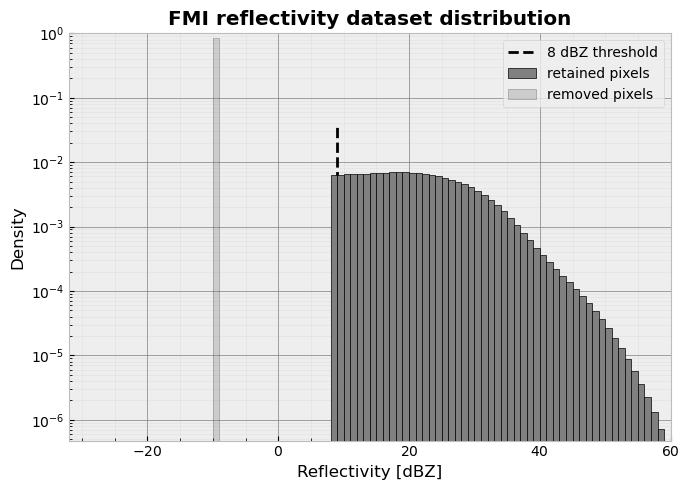

In [31]:
_, bins = np.histogram([], bins=n_bins, range=rng)

ncols = 1
nrows = 1
fig, ax = plt.subplots(
    figsize=(7*ncols, 5),
    nrows=nrows,
    ncols=ncols,
    squeeze=True,
    sharex="row",
)

width = bins[-1] - bins[-2]

ax.set_title("FMI reflectivity dataset distribution", fontweight="semibold")

ax.bar(
        bins[40:-1],
        hists["all"]["density"][40:],
        width=width,
        align="edge",
        color="gray",
        edgecolor="k",
        zorder=10,
        label="retained pixels"
    )
ax.bar(
        bins[:40],
        hists["all"]["density"][:40],
        width=width,
        align="edge",
        color="gray",
        edgecolor="k",
        zorder=10,
        alpha=0.3,
        label = "removed pixels"
    )
ax.vlines(x=[9.0], ymin=0, ymax=0.04, colors="k", linestyles="dashed", linewidth=2, label="8 dBZ threshold")

def gaus(x, a, x0, sigma):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

from scipy.optimize import curve_fit

x_to_fit = np.arange(bins[51]-len(bins[51:-1]),bins[51]+len(bins[51:-1]) )
y_to_fit = np.concatenate([hists["all"]["density"][51:][::-1],hists["all"]["density"][51:]])


ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0))
ax.set_ylim(bottom=0, top=1.0)
ax.set_xlim(rng)
ax.grid(which="major", lw=0.5, color="tab:gray", ls="-", zorder=0)
ax.grid(which="minor", lw=0.5, color="tab:gray", ls="-", alpha=0.1, zorder=0)


ax.set_yscale("log")
ax.legend()
ax.set_ylabel("Density")

ax.set_xlabel("Reflectivity [dBZ]")

fig.tight_layout()
fig.show()